In [1]:
%matplotlib inline
import nivapy3 as nivapy
import flux_calcs as flux
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.formula.api as smf
import glob
import warnings

#warnings.filterwarnings("ignore")
plt.style.use('ggplot')

# Mercury fluxes

Estimating Hg fluxes for 2018.

## 1. Chemistry data

### 1.1. Read chemistry data

In [19]:
# Read chemistry data
chem_xlsx = r'../Hg_Nor_Rivers_2018_JES.xlsx'
chem_df = pd.read_excel(chem_xlsx, sheet_name='For James')

# Not interested in MeHg for now
del chem_df['MeHg_ng/l']

chem_df.head()

,name,date,THg_ng/l,DHg_ng/l
0,Glomma,2018-01-08,1.437399,NaN
1,Glomma,2018-02-05,2.077273,NaN
2,Glomma,2018-03-04,0.767497,0.440
3,Glomma,2018-04-09,1.750000,0.772
4,Glomma,2018-05-07,2.870000,1.520


### 1.2. Plot chemistry data

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


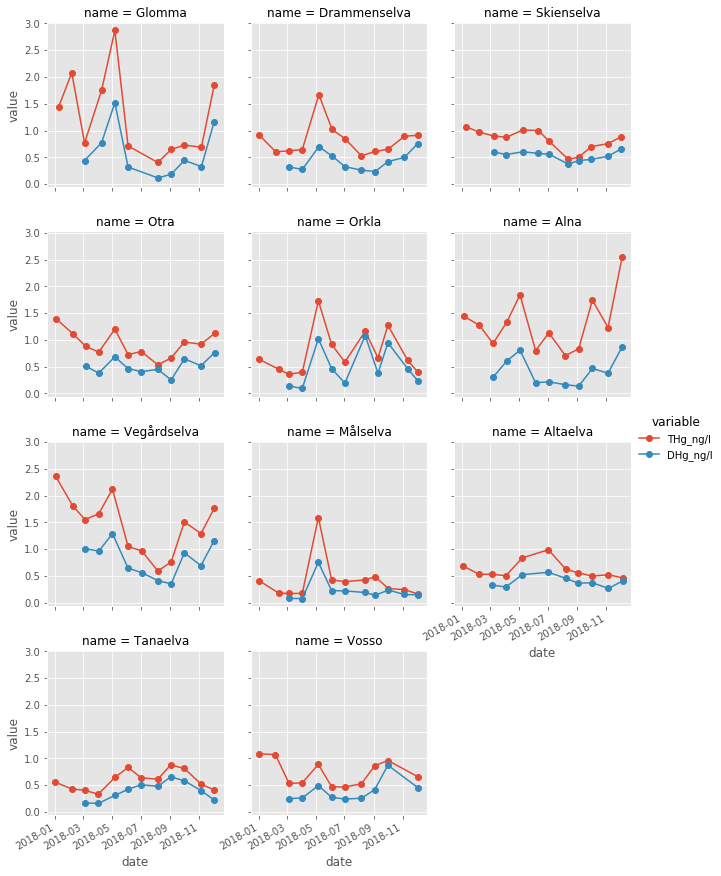

In [3]:
# Grid plot
chem_df_long = chem_df.melt(id_vars=['name', 'date'])
g = sn.FacetGrid(chem_df_long, hue='variable', col='name', col_wrap=3)
g = (g.map(plt.plot, 'date', 'value', marker='o').add_legend())
g.set_xticklabels(rotation=30, ha='right')

### 1.3. Patch missing DHg

Dissolved Hg was not measured during January or February. These values can be patched by OLS regression between THg and DHg for each station.

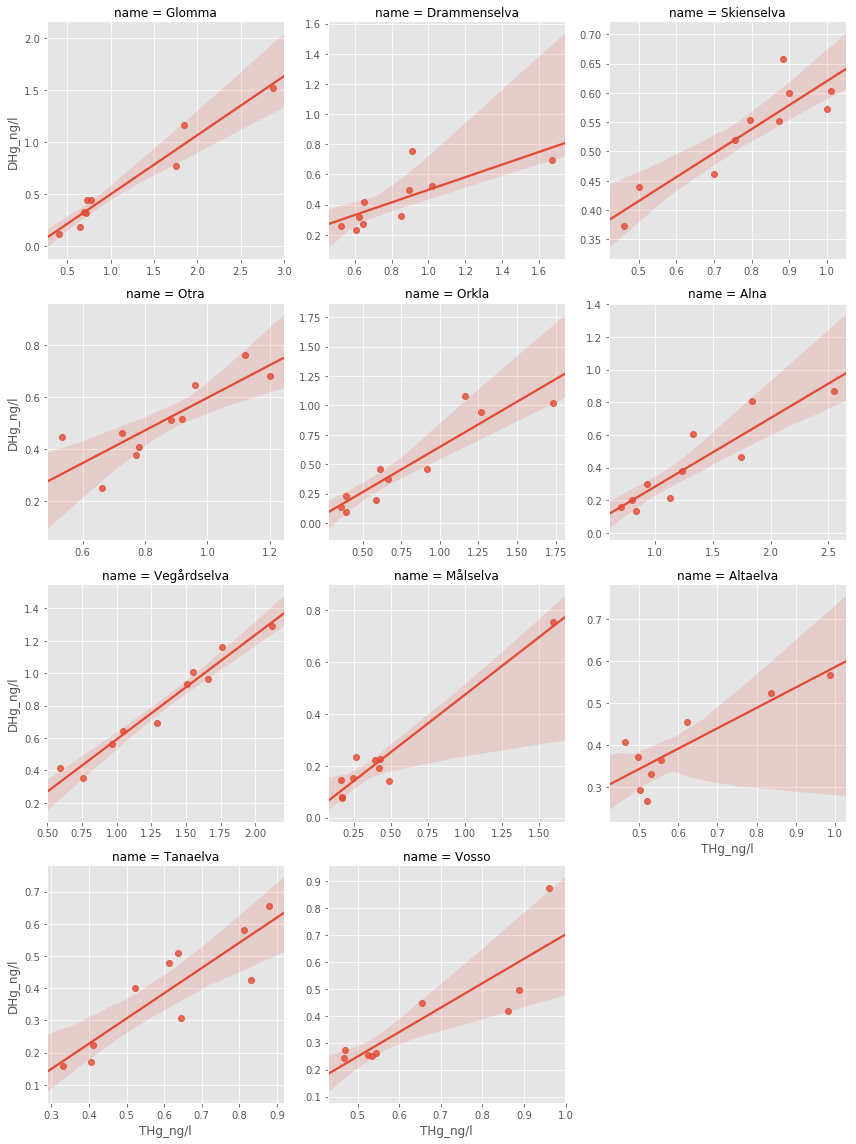

In [4]:
# Visualise OLS regression
sn.lmplot('THg_ng/l', 'DHg_ng/l', chem_df, col='name', col_wrap=3,
          sharex=False, sharey=False, height=4)

**Note:** The code below fits OLS regressions **assuming the intercept is zero**. This seems reasonable as if THg is zero, then DHg has to be zero too.

In [5]:
# Get list of stations
stns = chem_df['name'].unique()

# Dict for results
slp_dict = {}

# Loop over stations
for stn in stns:
    # Get data for station
    df = chem_df.query('name == @stn').dropna()
    
    # OLS regression
    res = smf.ols(formula='Q("DHg_ng/l") ~ Q("THg_ng/l") - 1', data=df).fit()
    
    # Store results
    slp_dict[stn] = res.params[0]
    
    # Plot diagnotsics
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    axes[0].plot(res.model.exog[:, 0], res.resid, 'ro')
    axes[0].set_xlabel('THg_ng/l')
    axes[0].set_ylabel('Residual')
    sn.distplot(res.resid.values, ax=axes[1])
    axes[1].set_xlabel('Residual')
    plt.suptitle(stn)
    plt.tight_layout()

    # Save png
    png_path = r'../regression_pngs/%s.png' % stn
    plt.savefig(png_path, dpi=300)
    plt.close()
    
    # Print summary
    print(f'{stn}:')
    print(f'    R2:    {res.rsquared:.2f}')
    print(f'    Slope: {res.params[0]:.2f}')

Glomma:
    R2:    0.98
    Slope: 0.53
Drammenselva:
    R2:    0.94
    Slope: 0.50
Skienselva:
    R2:    0.99
    Slope: 0.66
Otra:
    R2:    0.98
    Slope: 0.59
Orkla:
    R2:    0.94
    Slope: 0.65
Alna:
    R2:    0.94
    Slope: 0.33
Vegårdselva:
    R2:    0.99
    Slope: 0.61
Målselva:
    R2:    0.97
    Slope: 0.48
Altaelva:
    R2:    0.98
    Slope: 0.64
Tanaelva:
    R2:    0.96
    Slope: 0.65
Vosso:
    R2:    0.93
    Slope: 0.62


In [6]:
# Patch missing values
for idx, row in chem_df.iterrows():
    if pd.isnull(row['DHg_ng/l']):
        chem_df.at[idx, 'DHg_ng/l'] = chem_df.at[idx, 'THg_ng/l'] * slp_dict[row['name']]

chem_df.head()

,name,date,THg_ng/l,DHg_ng/l
0,Glomma,2018-01-08,1.437399,0.755613
1,Glomma,2018-02-05,2.077273,1.091983
2,Glomma,2018-03-04,0.767497,0.440000
3,Glomma,2018-04-09,1.750000,0.772000
4,Glomma,2018-05-07,2.870000,1.520000


## 2. Flow data

In [7]:
# Match names in HF's chemistry file to NVE's file_names
lookup_path = r'../nve_niva_stations_lookup.xlsx'
lookup_df = pd.read_excel(lookup_path)

# No flow data for Alna yet - ignore for now
lookup_df = lookup_df.query("NIVA_Station != 'Alna'")

lookup_df

,NIVA_Station,NVE_Station
0,Glomma,Solbergfoss
1,Drammenselva,Dovikfoss
2,Skienselva,Skotfoss
3,Otra,Heisel
4,Orkla,Syrstad
6,Vegårdselva,Lundevann
7,Målselva,Maalselva
8,Altaelva,Kista
9,Tanaelva,Polmak
10,Vosso,Bulken


### 2.1. Data checking

In [8]:
# Loop over stations
q_dict = {}
chem_dict = {}

for idx, row in lookup_df.iterrows():
    # Get chem data
    niva_name = row['NIVA_Station']
    stn_chem_df = chem_df.query("name == @niva_name")
    stn_chem_df.index = stn_chem_df['date']
    del stn_chem_df['name'], stn_chem_df['date']
    
    # Get path to flow data
    nve_name = row['NVE_Station']
    search_path = rf'../nve_flow_data_utf8/*_{nve_name}.csv'
    file_list = glob.glob(search_path)
    assert len(file_list) == 1
    file_path = file_list[0]
    
    # Read flow data
    q_df = pd.read_csv(file_path, names=['date', 'flow_m3/s'], 
                       header=None, skiprows=1, sep=';')
    q_df['date'] = pd.to_datetime(q_df['date'])
    q_df.index = q_df['date']
    del q_df['date']
    q_df = q_df.resample('D').mean()
    
    # For Skienselva, we use NVE data + 10 m3/s
    if niva_name == 'Skienselva':
        q_df = q_df + 10
    
    q_dict[niva_name] = q_df
    chem_dict[niva_name] = stn_chem_df
    
    # Print summary
    print(f'{niva_name}:')
    print('    Number of chem records: %s' % len(stn_chem_df))
    print('    Number of flow records: %s' % len(q_df.dropna(how='any')))

Glomma:
    Number of chem records: 11
    Number of flow records: 365
Drammenselva:
    Number of chem records: 12
    Number of flow records: 365
Skienselva:
    Number of chem records: 12
    Number of flow records: 365
Otra:
    Number of chem records: 12
    Number of flow records: 365
Orkla:
    Number of chem records: 12
    Number of flow records: 365
Vegårdselva:
    Number of chem records: 12
    Number of flow records: 365
Målselva:
    Number of chem records: 12
    Number of flow records: 365
Altaelva:
    Number of chem records: 11
    Number of flow records: 365
Tanaelva:
    Number of chem records: 12
    Number of flow records: 365
Vosso:
    Number of chem records: 11
    Number of flow records: 365


## 3. Estimate fluxes

The code below uses three different methods for estimating fluxes. Other methods will be available soon (Beale, OSPAR etc.), but I haven't had time to code them yet. It doesn't matter too much which method we use here, because we only have one chemistry sample per time period of interest anyway (i.e. one per month). All methods should therefore give similar(ly bad!) results. 

In [28]:
# Loop over stations
df_list = []

for stn in lookup_df['NIVA_Station'].values:
    q_df = q_dict[stn]
    chem_df = chem_dict[stn]
    
    print('############################################################################################################')
    print(f'Processing: {stn}.\n')
    # Estimate fluxes using 'simple means'
    mean_df = flux.estimate_fluxes(q_df, chem_df, agg_freq='M', method='simple_means')
    mean_df['station'] = stn
    mean_df['method'] = 'simple_means'
    df_list.append(mean_df)
    
    # Estimate fluxes using 'linear interpolation'
    interp_df = flux.estimate_fluxes(q_df, chem_df, agg_freq='M', method='linear_interpolation')
    interp_df['station'] = stn
    interp_df['method'] = 'linear_interpolation'
    df_list.append(interp_df)
    
    # Estimate fluxes using 'log-log linear regression'
    reg_df = flux.estimate_fluxes(q_df, chem_df, agg_freq='M', method='log_log_linear_regression')
    reg_df['station'] = stn
    reg_df['method'] = 'log-log_linear_regression'
    df_list.append(reg_df)

    print('\n')
    
# Combine
df = pd.concat(df_list, axis=0)
df.reset_index(inplace=True)
df = df[['station', 'date', 'method', 'flow_m3', 'THg_kg', 'DHg_kg']]

# Save output
out_csv = r'../hg_fluxes.csv'
df.to_csv(out_csv, index=False)
df.head()

############################################################################################################
Processing: Glomma.

Regression results:
      param     slope  intercept  r_squared
0  THg_ng/l  0.300304  -0.812235   0.039713
1  DHg_ng/l  0.379572  -1.362301   0.037688


############################################################################################################
Processing: Drammenselva.

Regression results:
      param     slope  intercept  r_squared
0  THg_ng/l  0.363731  -0.973346   0.420096
1  DHg_ng/l  0.484854  -1.561700   0.513776


############################################################################################################
Processing: Skienselva.

Regression results:
      param     slope  intercept  r_squared
0  THg_ng/l  0.414579  -1.096045   0.286732
1  DHg_ng/l  0.316666  -1.024542   0.354505


############################################################################################################
Processing: Otra.

Regression

,station,date,method,flow_m3,THg_kg,DHg_kg
0,Glomma,2018-01-31,simple_means,1.550247e+09,2.228323,1.171387
1,Glomma,2018-02-28,simple_means,1.188916e+09,2.469703,1.298276
2,Glomma,2018-03-31,simple_means,9.637998e+08,0.739714,0.424072
3,Glomma,2018-04-30,simple_means,1.659447e+09,2.904032,1.281093
4,Glomma,2018-05-31,simple_means,5.191490e+09,14.899576,7.891065


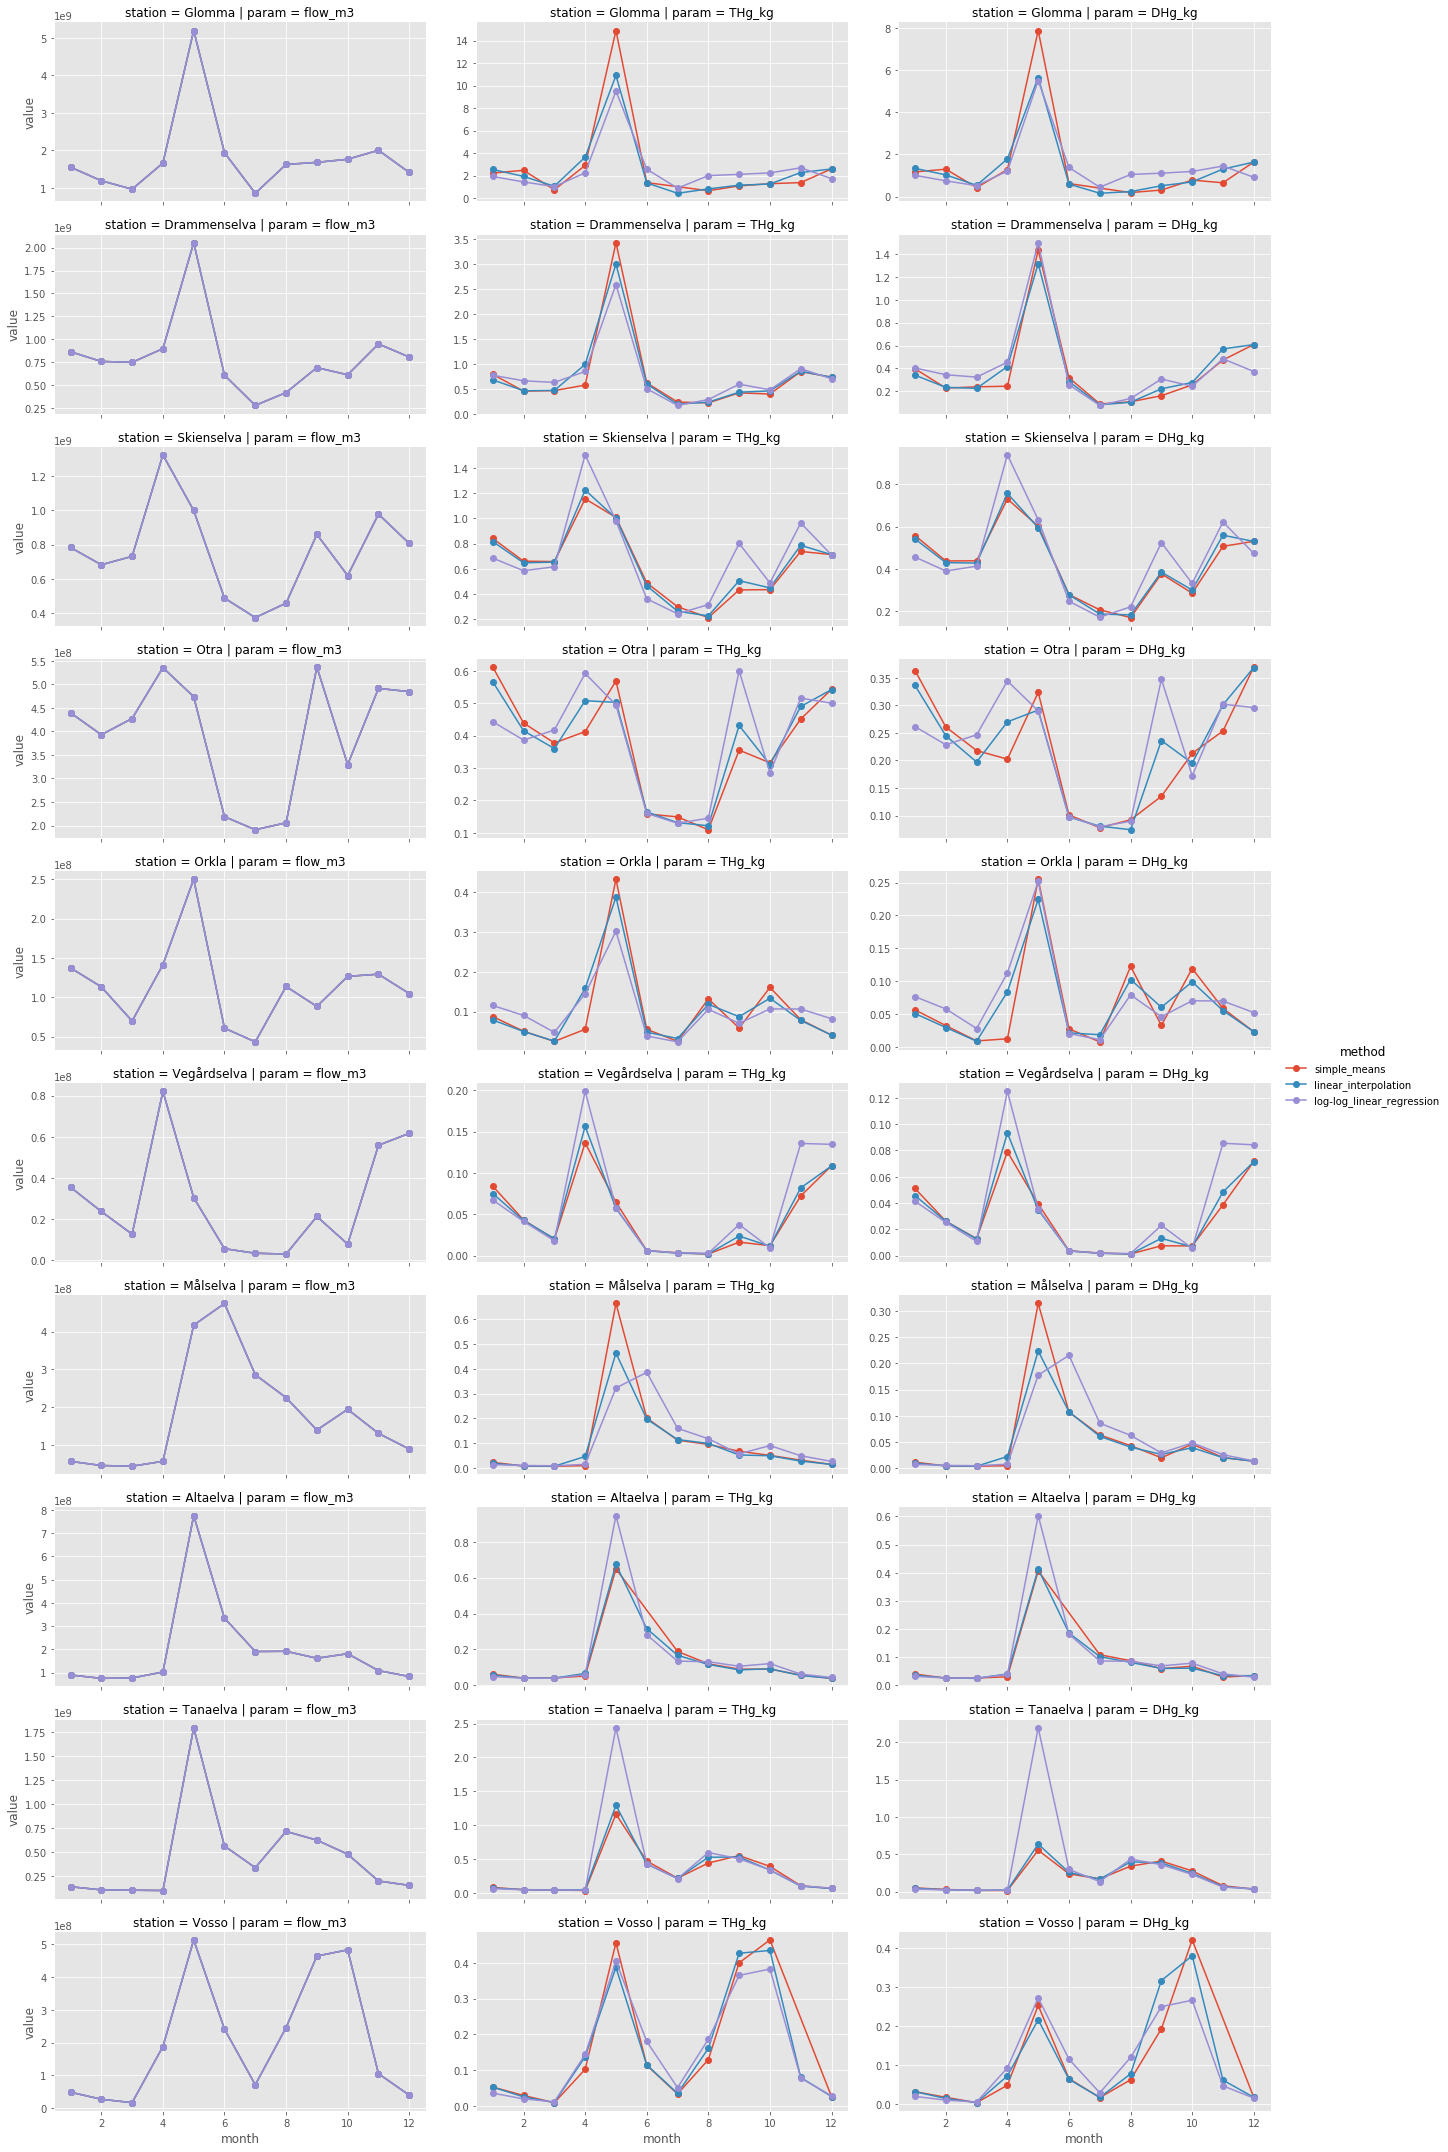

In [29]:
# Melt to long format
df2 = df.melt(id_vars=['date', 'station', 'method'], var_name='param').copy()
df2['month'] = df2['date'].dt.month

# Grid plot
g = sn.FacetGrid(df2, hue='method', row='station', col='param', 
                 sharey=False, aspect=2)
g = (g.map(plt.plot, 'month', 'value', marker='o').add_legend())

out_png = r'../hg_fluxes.png'
plt.savefig(out_png, dpi=300)